# REF
- **https://jeinalog.tistory.com/15**
- **https://github.com/jeina7/Handwriting_styler**
- https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
- https://realblack0.github.io/2020/05/11/transpose-convolution.html
- https://hyunlee103.tistory.com/63
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://stackoverflow.com/questions/62133737/how-does-pytorchs-loss-backward-work-when-retain-graph-true-is-specified (detach)
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/gan_font_interpolation'

#utils.py

In [ ]:
# utils.py

import numpy as np


def norm_img(img):
    return img / (255/2) - 1
def denorm_img(img):
    return ((img + 1) / 2).clamp(0, 1)

def tight_crop_image(img, resize_fix=False):
    x1=img.shape[0]
    x2=0
    y1=img.shape[0]
    y2=0

    index=0
    for i in img:
      tmp = np.array(np.where(i!=255))
      tmp = tmp[0]
      if len(tmp)!=0:
        if index <= y1:
          y1 = index
        if index >= y2:
          y2 = index
        if tmp[np.argmin(tmp)] < x1:
          x1 = tmp[np.argmin(tmp)]
        if tmp[np.argmax(tmp)] > x2:
          x2 = tmp[np.argmax(tmp)]
      index+=1

    cropped_image = img[y1:y2+1, x1:x2+1]
    
    return cropped_image


def add_padding(img, image_size=128, pad_value=None):
    height, width = img.shape
    if not pad_value:
        pad_value = img[0][0]
    
    # Adding padding of x axis - left, right
    pad_x_width = (image_size - width) // 2
    pad_x = np.full((height, pad_x_width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_x, img), axis=1)
    img = np.concatenate((img, pad_x), axis=1)
    
    width = img.shape[1]

    # Adding padding of y axis - top, bottom
    pad_y_height = (image_size - height) // 2
    pad_y = np.full((pad_y_height, width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_y, img), axis=0)
    img = np.concatenate((img, pad_y), axis=0)
    
    # Match to original image size
    width = img.shape[1]
    if img.shape[0] % 2:
        pad = np.full((1, width), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=0)
    height = img.shape[0]
    if img.shape[1] % 2:
        pad = np.full((height, 1), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=1)
    
    return img


def centering_image(img, image_size=128, resize_fix=False, pad_value=None):
    if not pad_value:
        pad_value = img[0][0]
    cropped_image = tight_crop_image(img, resize_fix=resize_fix)
    centered_image = add_padding(cropped_image, image_size=image_size, pad_value=pad_value)
    
    return centered_image

# dataload.py

In [ ]:
# dataload.py

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np

import matplotlib.pyplot as plt
import pickle

import os.path
# from .utils import norm_img, denorm_img, tight_crop_image, add_padding, centering_image

# draw
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color=255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)

    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    # 해당 font에 글자 없을시
    if flag == 255 * 128 * 128:
        print('[warning] 폰트 없음 :', ch)
        return None

    if w>canvas_size or h>canvas_size:
        print('[warning] 사이즈를 맞춰주세요')

    return image


# ttf to pickle
def ttf_to_pkl(text, font_path, pkl_path, canvas_size=128, font_size=90):
    font = ImageFont.truetype(font=font_path, size=font_size)

    text_img = []

    for i in text:
        img = draw_single_char(i, font, canvas_size)
        text_img.append(np.array(img))

    with open(pkl_path, 'wb') as f:
        pickle.dump(text_img, f)


def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

## ★ 이렇게 해도 되나? c_vec 생성기 따로 빼달라고 하신 것 같아서 일단 빼봄
def init_embedding(PATH, cg_num, char_num):
  c_vec = np.random.normal(size=(cg_num, 128, 1, 1), scale=0.9)
  torch.save(c_vec.reshape(cg_num, 1, 128), PATH + '/save/categorical_vector.pth')
  print("[Success] Saved 'categorical vector' in" + PATH + '/save')
  c_vec_t = torch.FloatTensor([c_vec[i] for i in range(cg_num) for _ in range(char_num)])
  c_vec_t = c_vec_t.cuda()
  return c_vec_t


def center_align(source, target):
    re_source = []
    for i in source:
      cen = centering_image(i, image_size =128)
      re_source.append(cen)

    re_target = []
    for i in target:
      tmp = []
      for j in i:
        cen = centering_image(j, image_size=128)
        tmp.append(cen)
      re_target.append(tmp)

    source = np.array(re_source)
    target = np.array(re_target)
    return source, target

def get_text():
    upper = "A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z"
    lower = "a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z"
    number = "0, 1, 2, 3, 4, 5, 6, 7, 8, 9"

    text = (upper+', '+lower+', '+number).split(", ")

    # text = (upper+', '+lower).split(", ")
    # text = number.split(", ")
    return text

# load train data from directory
def load_train_data(PATH, num_of_style = 5):
    text = get_text()

    files = os.listdir(PATH + '/font') ## ★ 디렉토리 부분은 어떡해야 할지 잘 모르겠음

    ttf_to_pkl(text, PATH +'/font/' + 'NanumGothic-Regular.ttf', 'NanumGothic-Regular.pkl', canvas_size=128)
    source = load_pkl('NanumGothic-Regular.pkl')
    source = np.array(source)

    t_array = []
    for (num, f) in enumerate(files):
      if num == num_of_style:
        break
      font_path = os.path.join(PATH + '/font', f)

      filename, _ = os.path.splitext(f)
      pkl_path = filename + '.pkl'
      ttf_to_pkl(text, font_path, pkl_path, canvas_size = 128)

      t_array.append(load_pkl(pkl_path))
    
    target = np.array(t_array)

    source, target = center_align(source, target)

    # making tensor
    source_tensor = torch.FloatTensor(source)
    target_tensor = torch.FloatTensor(target)

    source_tensor = norm_img(source_tensor)
    target_tensor = norm_img(target_tensor)

    cg_num, font_num = target_tensor.shape[0], target_tensor.shape[1]

    torch.save(source_tensor, PATH + '/save/source_tensor.pth')
    torch.save(target_tensor, PATH + '/save/target_tensor.pth')
    print("[Success] Saved 'source tensor' and 'target tensor' in" + PATH + '/save')

    c_vec_t = init_embedding(PATH, cg_num, font_num)
    print('[Success]: loaded train data')
    return source_tensor, target_tensor, c_vec_t

# models.py

In [ ]:
# models.py

import torch
import torch.nn as nn
import torch.optim as optim

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        cs = 64

        # in, out, k, s, p, d
        self.e1 = nn.Sequential(
            nn.Conv2d(1, cs, 5, 2, 2)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 5, 2, 2),
            # nn.InstanceNorm2d(cs*2),
            # nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 5, 2, 2),
            # nn.InstanceNorm2d(cs*4),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 5, 2, 2),
            # nn.InstanceNorm2d(cs*8),
            nn.BatchNorm2d(cs*8),
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 5, 2, 2),
            # nn.InstanceNorm2d(cs*8),
            nn.BatchNorm2d(cs*8),
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 5, 2, 2),
            # nn.InstanceNorm2d(cs*8),
            nn.BatchNorm2d(cs*8)
        )
        self.e7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 5, 2, 2),
            # nn.BatchNorm2d(cs*8)
        )

        self.e1.apply(init_weights)
        self.e2.apply(init_weights)
        self.e3.apply(init_weights)
        self.e4.apply(init_weights)
        self.e5.apply(init_weights)
        self.e6.apply(init_weights)
        self.e7.apply(init_weights)

    def forward(self, x):
        d = dict()
        x = self.e1(x)
        d['e1'] = x
        x = self.e2(x)
        d['e2'] = x
        x = self.e3(x)
        d['e3'] = x
        x = self.e4(x)
        d['e4'] = x
        x = self.e5(x)
        d['e5'] = x
        x = self.e6(x)
        d['e6'] = x
        x = self.e7(x)
        d['e7'] = x
        return x, d

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        cs = 64

        # 128 = style vector
        self.d1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8+128, cs*8, 3, 1, 1), # e1이랑 합치기위해 유지
            nn.BatchNorm2d(cs*8),
            # nn.InstanceNorm2d(cs*8),
            nn.Dropout(0.5)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 5, 2, 2, 1),
            nn.BatchNorm2d(cs*8),
            # nn.InstanceNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 5, 2, 2, 1),
            nn.BatchNorm2d(cs*8),
            # nn.InstanceNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 5, 2, 2, 1),
            nn.BatchNorm2d(cs*8),
            # nn.InstanceNorm2d(cs*8),
        )
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*4, 5, 2, 2, 1),
            nn.BatchNorm2d(cs*4),
            # nn.InstanceNorm2d(cs*4),
        )
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8, cs*2, 5, 2, 2, 1),
            nn.BatchNorm2d(cs*2),
            # nn.InstanceNorm2d(cs*2),
        )
        self.d7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*4, cs, 5, 2, 2, 1),
            nn.BatchNorm2d(cs),
            # nn.InstanceNorm2d(cs),
        )
        self.d8 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*2, 1, 5, 2, 2, 1),
            # nn.BatchNorm2d(cs),
            # nn.LeakyReLU(0.2),
            # nn.Sigmoid(),
            nn.Tanh(),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.d5.apply(init_weights)
        self.d6.apply(init_weights)
        self.d7.apply(init_weights)
        self.d8.apply(init_weights)

    def forward(self, x, e):
        x = self.d1(x)
        x = torch.cat((x, e['e7']), dim=1)
        x = self.d2(x)
        x = torch.cat((x, e['e6']), dim=1)
        x = self.d3(x)
        x = torch.cat((x, e['e5']), dim=1)
        x = self.d4(x)
        x = torch.cat((x, e['e4']), dim=1)
        x = self.d5(x)
        x = torch.cat((x, e['e3']), dim=1)
        x = self.d6(x)
        x = torch.cat((x, e['e2']), dim=1)
        x = self.d7(x)
        x = torch.cat((x, e['e1']), dim=1)
        x = self.d8(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, category_num):
        super(Discriminator, self).__init__()
        cs = 64

        self.category_num = category_num

        self.d1 = nn.Sequential(
            # nn.LeakyReLU(0.2),
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.fc_tf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, 1),
        )
        self.fc_cg = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, category_num),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.fc_tf.apply(init_weights)
        self.fc_cg.apply(init_weights)

    def forward(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)

        tf = self.fc_tf(x)
        cg = self.fc_cg(x)

        return tf, cg

# performance.py


In [ ]:
import torch
import cv2 # Image processing
from scipy.stats import norm # gaussian distribution sampling 

def loadData(PATH):
    PATH = PATH + '/save'
    source_tensor = torch.load(PATH + '/source_tensor.pth')
    target_tensor = torch.load(PATH + '/target_tensor.pth')
    c_vector = torch.load(PATH + '/categorical_vector.pth')
    return source_tensor, target_tensor, c_vector


def loadModel(PATH, epoch):
    PATH = PATH + '/save/'
    encoder = torch.load(PATH+'encoder-'+str(epoch)+'.pth')
    decoder = torch.load(PATH+'decoder-'+str(epoch)+'.pth')
    discriminator = torch.load(PATH+'discriminator-'+str(epoch)+'.pth')

    encoder.eval()
    decoder.eval()
    discriminator.eval()

    return encoder, decoder, discriminator


def processed_image(img, kernel_size= 5, kernel_shape= 'ellipse', iteration = 1):
  # [kernel shape] DEFAULT: 'ellipse', OPTION: 'ellipse', 'rect', 'cross'

  if kernel_shape == 'ellipse':
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
  elif kernel_shape == 'rect':
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
  elif kernel_shape == 'cross':
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))
  else:
    print('[warning] wrong \'kernel_shape\' input. Try with \'ellipse\', \'rect\' or \'cross\'.')

  result_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations= 1)
  result_img = cv2.morphologyEx(result_img, cv2.MORPH_CLOSE, kernel, iterations= 1)

  result_img = torch.from_numpy(result_img)
  return result_img

def generate(encoder, decoder, discriminator, source_tensor, c_vec, ch, style):
    encoder.eval()
    decoder.eval()
    discriminator.eval()
    
    x = torch.FloatTensor(source_tensor[ch]).view((1, 1, 128, 128)).cuda()
    c = torch.FloatTensor(c_vec[style]).view((1, 128, 1, 1)).cuda()
    # print(c.shape)
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach()
    # print(d_out.shape)
    # print(d_out)
    image = d_out.cpu()
    denorm_image = denorm_img(image)
    return image, denorm_image

def custom_generate(encoder, decoder, discriminator, source_tensor, c_vec, ch):
    encoder.eval()
    decoder.eval()
    discriminator.eval()

    x = torch.FloatTensor(source_tensor[ch]).view((1, 1, 128, 128)).cuda()
    c = torch.FloatTensor(c_vec).view((1, 128, 1, 1)).cuda()
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach()
    image = d_out.cpu()
    denorm_image = denorm_img(image)
    return image, denorm_image

def sub_distance(a, b, s):
    return a + (b - a) * s

def sample_normal_distribution(num_of_point = 100):
  rv = norm(loc = 0, scale = 1)
  n = num_of_point+1

  end_point = 1 - 1/n
  start_point = 1/n
  width = rv.ppf(end_point) - rv.ppf(start_point)
  zero_point = rv.ppf(end_point)

  normDisInvList = []
  for i in range(1, n):
    normDisInvList.append((rv.ppf(i/n)+zero_point)/width*num_of_point)
  return normDisInvList

# 스크롤 cvec 시각화
def print_scroll_vec(a, b, n=10, norm=False):
    if norm:
      pointlist = sample_normal_distribution(n)
    else:
      pointlist = range(n)
    
    for point in pointlist:
      sp = sub_distance(a, b, point).numpy()[0]
      plt.scatter(sp[0], sp[1])
    plt.show()


# 스크롤 image 출력
def print_scroll_img(encoder, decoder, discriminator, source_tenser, a, b, ch=0, n=10, norm = False, imshow=False, process = False):
    arr = []
    if norm:
      pointlist = sample_normal_distribution(n)
    else:
      pointlist = range(n)

    for i in pointlist:
        sp = sub_distance(a, b, i/(n-1)).numpy()[0]
        image, denorm_image = custom_generate(encoder, decoder, discriminator, source_tensor, sp.reshape(1, 128, 1, 1), ch)
        denorm_image = denorm_image[0,0]
        if process:
          denorm_image = processed_image(denorm_image.numpy(), kernel_size = 5)
        if imshow:
            plt.imshow(denorm_image, cmap='gray')
            plt.show()
        arr.append(denorm_image)
    return arr



# train.py

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # shift_and_resize_image 에만 들어감
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# from .models import Encoder, Decoder, Discriminator

def shift_and_resize_image(source_set, target_set):
    batch_size, channel, w, h = source_set.shape
    multiplier = np.random.uniform(1.00, 1.20)
    nw, nh = int(w * multiplier) + 1, int(h * multiplier) + 1
    
    shift_x = int(np.ceil(np.random.uniform(low= 0.01, high= nw-w)))
    shift_y = int(np.ceil(np.random.uniform(low = 0.01, high = nh-h)))

    src_out = F.interpolate(source_set, size = [nw, nh], mode='bilinear', align_corners=True)
    tar_out = F.interpolate(target_set, size = [nw, nh], mode='bilinear', align_corners=True)

    src_out = src_out[:, :, shift_x : shift_x + w , shift_y : shift_y + h]
    tar_out = tar_out[:, :, shift_x : shift_x + w , shift_y : shift_y + h]

    return src_out, tar_out

def gprint(encoder, decoder, discriminator, source_tensor, target_tensor, c_vec, ch):
    cg_num = target_tensor.shape[0]
    g_list = []
    dg_list = []
    for i in range(cg_num):
      g, dg = generate(encoder, decoder, discriminator, source_tensor, c_vec, ch, i)
      g_list.append(g)
      dg_list.append(dg)
    plt.figure(figsize=(25, 4))
    plt.title('Real')
    for i in range(cg_num):
      plt.subplot(1, cg_num, i+1)
      plt.imshow(target_tensor[i, ch], cmap = 'gray')
    plt.show()
    plt.figure(figsize=(25, 4))
    for i in range(cg_num):
      plt.title('Fake')
      plt.subplot(1, cg_num, i+1)
      plt.imshow(dg_list[i].cpu().numpy()[0, 0], cmap='gray')
    plt.show()
  

def train(PATH, epochs = 200, batch_size = 16, check_point = 30, learning_rate = 0.0001, num_of_style = 5, verbose = False):
    # load dataset
    source_tensor, target_tensor, c_vec_t = load_train_data(PATH, num_of_style = num_of_style)

    cg_num, font_num = target_tensor.shape[0], target_tensor.shape[1]

    x_data = torch.FloatTensor(source_tensor).repeat(cg_num, 1, 1).view((cg_num * font_num, 1, 128, 128)) 
    t_data = torch.FloatTensor(target_tensor).view((cg_num * font_num, 1, 128, 128))
    t_meta = torch.LongTensor([[j, i] for j in range(cg_num) for i in range(font_num)]) # [cg, font]

    x_data = x_data.cuda()
    t_data = t_data.cuda()

    c_vec = torch.load(PATH + '/save/categorical_vector.pth')

    dataset = TensorDataset(x_data, t_data, t_meta, c_vec_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # make models
    encoder = Encoder().cuda()
    decoder = Decoder().cuda()
    discriminator = Discriminator(category_num=cg_num).cuda()


    encoder.train()
    decoder.train()
    discriminator.train()

    l1_criterion = nn.L1Loss().cuda()
    bce_criterion = nn.BCEWithLogitsLoss().cuda()
    ce_criterion = nn.CrossEntropyLoss().cuda()
    mse_criterion = nn.MSELoss().cuda()

    g_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

    L1_W = 100
    MSE_W = 15
    # L1_W = 100
    # MSE_W = 15

    print('batch_size: %d, category_num: %d, font_num: %d'%(batch_size, cg_num, font_num))
    log = []

    for epoch in range(epochs):
        
        encoder.train()
        decoder.train()
        discriminator.train()

        d_total_loss = []
        g_total_loss = []

        l1_loss_arr = []
        ff_bce_loss_arr = []
        bce_loss_arr = []
        ce_loss_arr = []
        z_loss_arr = []

        for x, t, tm, c in loader:
            
            # shift를 위한
            x, t = shift_and_resize_image(x, t) 

            cg = tm.T[0]
            font = tm.T[0]

            z, e_net = encoder(x)
            
            d_in = torch.cat((z, c), dim=1)
            d_out = decoder(d_in, e_net)

            real_tf, real_cg = discriminator(t)
            fake_tf, fake_cg = discriminator(d_out)

            # 정답 텐서
            one_tensor = torch.ones(x.shape[0], 1).cuda()
            zero_tensor = torch.zeros(x.shape[0], 1).cuda()

            # [dis] 가짜 검출 로스
            r_bce_loss = bce_criterion(real_tf, one_tensor)
            f_bce_loss = bce_criterion(fake_tf, zero_tensor)
            bce_loss = r_bce_loss + f_bce_loss
            
            # [dis] 카테고리 예측 로스
            category = torch.FloatTensor(np.array(np.eye(cg_num)[cg])).cuda() 
            r_ce_loss = bce_criterion(real_cg, category)
            f_ce_loss = bce_criterion(fake_cg, category) # 카테고리 예측 로스
            ce_loss = 0.5*(r_ce_loss + f_ce_loss)

            # [gen.en] z vector 유사도 로스
            t_z = encoder(d_out)[0] ## 원래 t였는데 레퍼런스 보고 바꿈. 이거 한 번 실험해봐야 한다.
            z_loss = mse_criterion(z, t_z)

            # [gen] 타겟 유사도 로스
            l1_loss = l1_criterion(d_out, t)

            # [gen] 변조 성공 로스
            ff_bce_loss = bce_criterion(fake_tf, one_tensor)

            # loss grad
            g_loss = (L1_W * l1_loss) + ff_bce_loss + (MSE_W * z_loss) + f_ce_loss
            d_loss = bce_loss + ce_loss

            # discriminator
            discriminator.zero_grad()
            d_loss.backward(retain_graph=True)

            # generator
            encoder.zero_grad()
            decoder.zero_grad()
            g_loss.backward(retain_graph=True)

            g_optimizer.step()
            d_optimizer.step()

            # log
            d_total_loss.append(d_loss.item())
            g_total_loss.append(g_loss.item())

            l1_loss_arr.append(l1_loss.item())
            ff_bce_loss_arr.append(ff_bce_loss.item())
            bce_loss_arr.append(bce_loss.item())
            ce_loss_arr.append(ce_loss.item())
            z_loss_arr.append(z_loss.item())

        log.append([d_total_loss, g_total_loss, l1_loss_arr, ff_bce_loss_arr, bce_loss_arr, ce_loss_arr, z_loss_arr])
        if verbose:
          print('epoch: %d/%d\tg_loss: %f\td_loss: %f'%(epoch+1, epochs, sum(g_total_loss), sum(d_total_loss)))
          if (epoch+1) % 10 == 0:
              gprint(source_tensor, target_tensor, c_vec, np.random.randint(0, source_tensor.shape[0]))

        if (epoch+1) % check_point == 0 or (epoch+1) == epochs:
            torch.save(encoder, PATH+'/save/encoder-'+str(epoch+1)+'.pth')
            torch.save(decoder, PATH+'/save/decoder-'+str(epoch+1)+'.pth')
            torch.save(discriminator, PATH+'/save/discriminator-'+str(epoch+1)+'.pth')          
            print('epoch: %d 체크포인트 저장'%(epoch+1))

# 돌리기


In [ ]:
# train(PATH, epochs =300, check_point = 30, learning_rate = 0.0001)

In [ ]:
source_tensor, target_tensor, c_vec = loadData(PATH)

In [ ]:
encoder, decoder, discriminator = loadModel(PATH, epoch = 300)

In [ ]:
cg_num = target_tensor.shape[0]

c_units = torch.FloatTensor(c_vec.reshape(cg_num, 1, 128))
# image_arr = print_scroll_img(encoder, decoder, discriminator, source_tensor, c_units[0], c_units[1], ch=38, n=10, imshow=True, norm =True)

In [ ]:
# print_scroll_vec(c_units[0], c_units[1], n=20, norm=True)

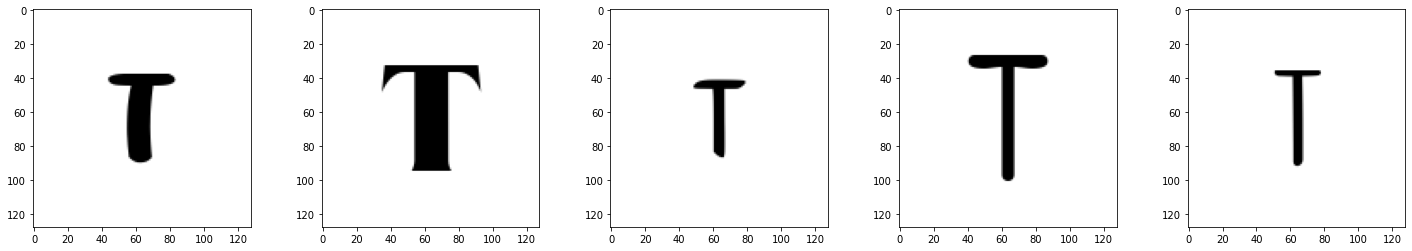

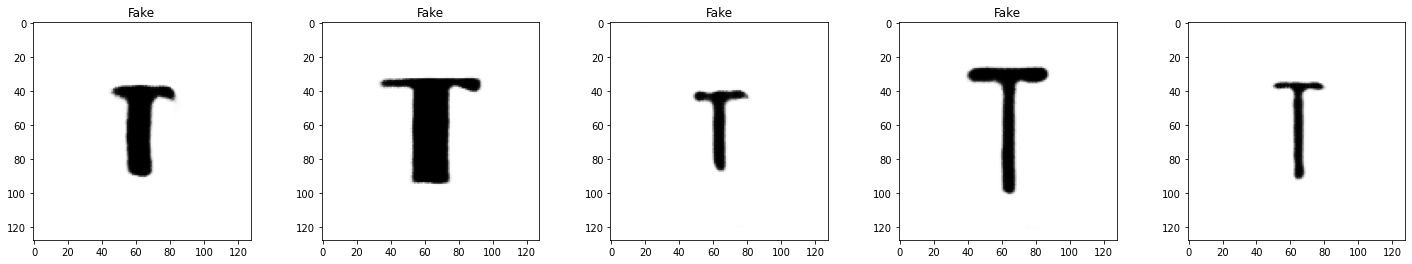

In [ ]:
# gprint(encoder, decoder, discriminator,source_tensor, target_tensor, c_vec, ch=19)

# 시각화 

## 움짤만들기 / 저장

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()
plt.close()

ax.set_xlim((0, 128))
ax.set_ylim((128, 0))

image_arr = print_scroll_img(encoder, decoder, discriminator, source_tensor, c_units[1], c_units[4], ch=23, n=50, imshow=False, norm = True)

im = ax.imshow(image_arr[0], cmap='gray')
def init():
    im.set_data(image_arr[0])
    return [im]
def animate(i):
    im.set_array(image_arr[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(image_arr), interval=100, blit=True)
anim.save('anim4.gif', writer='pillow', fps=60)
rc('animation', html='jshtml')
anim

In [ ]:
# s, t = shift_and_resize_image(source_tensor.reshape(62, 1, 128, 128), target_tensor)
# plt.subplot(1, 2, 1)
# plt.imshow(source_tensor[60], cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(s[60][0], cmap = 'gray')

In [ ]:
# anim.save('anim3.gif', writer='pillow', fps=60)

# 웹 관련

In [ ]:
!pip install flask-ngrok
!pip install flask_cors

In [ ]:
import pickle
import base64
from io import BytesIO
from PIL import Image

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request
from flask_cors import CORS

import pickle
import base64
from io import BytesIO
from PIL import Image

text = get_text()

encoder, decoder, discriminator = loadModel(PATH, 300)

app = Flask(__name__)

run_with_ngrok(app)
CORS(app)

@app.route('/api/pick', methods=['GET'])
def test_router():
    ch_c = request.args["ch"]
    ch = text.index(ch_c)
    start_font = int(request.args["start"])
    end_font = int(request.args["end"])

    temp = print_scroll_img(encoder, decoder, discriminator,source_tensor, c_units[start_font], c_units[end_font], ch=ch, n=100, norm=True)
    img = np.around(torch.cat(temp, dim=0).view(100, 128, 128).numpy()*255)

    b64_arr = []
    for i in range(0, len(img)):
        rawBytes = BytesIO()
        img_buffer = Image.fromarray(img[i].astype('uint8'))

        img_buffer.save(rawBytes, 'PNG')
        rawBytes.seek(0)
        base64_img = base64.b64encode(rawBytes.read()).decode('ascii')
        b64_arr.append(base64_img)

    return jsonify({
        'images': b64_arr
    })

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://923a172ad14a.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [11/Jan/2021 14:26:38] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [11/Jan/2021 14:26:51] "GET /api/pick?ch=d&start=1&end=3 HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 14:27:12] "GET /api/pick?ch=D&start=1&end=3 HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 14:28:10] "GET /api/pick?ch=X&start=0&end=4 HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 14:28:26] "GET /api/pick?ch=F&start=0&end=1 HTTP/1.1" 200 -
